Check how consistent is the image responses across sessions.
Maybe using it to fit slope and intercept

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, MultiTaskLassoCV
from neural_regress.regress_lib import MultiOutputSeparateLassoCV
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features, transform_features2Xdict
from neural_regress.regress_eval_lib import compute_D2_per_unit
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

In [4]:
"vvs-accentuate-day1_normalize_red_20241212-20241220.h5" # day 1 neural data
"vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5" # day 3 neural data 
"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli/results_12-01-2025" # generated accentuated stimuli  

stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"

datapath_day1 = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
datapath_day3 = join(ephys_root, "vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5")

imgdir_shared = join(stimuli_root, "shared1000")
imgdir_day1 = join(stimuli_root, "stimuli_pilot_20241119/results")
imgdir_day3 = join(stimuli_root, "results_12-01-2025")

In [5]:
# data_fulldict_day1 = load_from_hdf5(datapath_day1,)
# data_fulldict_day3 = load_from_hdf5(datapath_day3,)
subject_id1 = "red_20241212-20241220"
subject_id3 = "red_20250123-20250126"
data_dict_day1 = load_neural_data(datapath_day1, subject_id1, None)
data_dict_day3 = load_neural_data(datapath_day3, subject_id3, None)

In [6]:
data_dict_day1["image_fps"] = parse_image_fullpaths(data_dict_day1["stimulus_names"], [imgdir_shared, imgdir_day1])
data_dict_day3["image_fps"] = parse_image_fullpaths(data_dict_day3["stimulus_names"], [imgdir_shared, imgdir_day3])

All stimulus files were found
All stimulus files were found


In [7]:
list(data_dict_day1)

['brain_area',
 'ncsnr',
 'reliability',
 'stim_pos',
 'stim_size',
 'resp_mat',
 'resp_temp_mat',
 'image_fps',
 'stimulus_names']

In [8]:
# Find shared stimulus names and their indices
stim_names1 = data_dict_day1["stimulus_names"]
stim_names3 = data_dict_day3["stimulus_names"]

shared_stims = list(set(stim_names1) & set(stim_names3))
idx_shared_day1 = [i for i, name in enumerate(stim_names1) if name in shared_stims]
idx_shared_day3 = [i for i, name in enumerate(stim_names3) if name in shared_stims]

print(f"Found {len(shared_stims)} shared stimuli")
print("\nFirst few shared stimuli:")
print(shared_stims[:5])
print("\nCorresponding indices in day1:", idx_shared_day1[:5])
print("Corresponding indices in day3:", idx_shared_day3[:5])

Found 200 shared stimuli

First few shared stimuli:
['shared0026_nsd04130.png', 'shared0185_nsd15129.png', 'shared0072_nsd07121.png', 'shared0208_nsd17231.png', 'shared0164_nsd13654.png']

Corresponding indices in day1: [228, 229, 230, 231, 232]
Corresponding indices in day3: [3220, 3221, 3222, 3223, 3224]


In [9]:
respmat1_shared = data_dict_day1["resp_mat"][idx_shared_day1, :]
respmat3_shared = data_dict_day3["resp_mat"][idx_shared_day3, :]
respmat1_shared.shape
respmat3_shared.shape


(200, 64)

In [11]:
import numpy as np
def compute_linear_fit(x, y):
    """
    Compute the slope, intercept, and R² value for a linear fit between x and y.
    
    Parameters:
        x (array-like): Independent variable data.
        y (array-like): Dependent variable data.
    
    Returns:
        slope (float): Slope of the linear fit.
        intercept (float): Intercept of the linear fit.
        r_squared (float): Coefficient of determination.
    """
    # Compute slope and intercept using np.polyfit
    slope, intercept = np.polyfit(x, y, 1)
    # Calculate the predicted y values using the linear model
    y_pred = slope * x + intercept
    # Calculate residual sum of squares
    ss_res = np.sum((y - y_pred) ** 2)
    # Calculate total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # Calculate R^2 value
    r_squared = 1 - ss_res / ss_tot
    return slope, intercept, r_squared

# Example usage:
# channel = 7
# resp_x = respmat1_shared[:, channel]
# resp_y = respmat3_shared[:, channel]
# slope, intercept, r_squared = compute_linear_fit(resp_x, resp_y)
# print(f"slope: {slope:.2f}, intercept: {intercept:.2f}, R^2: {r_squared:.2f}")

In [12]:
channel = 1
for channel in range(respmat1_shared.shape[1]):
    resp_x = respmat1_shared[:, channel]
    resp_y = respmat3_shared[:, channel]
    slope, intercept, R2 = compute_linear_fit(resp_x, resp_y)
    print(f"Channel {channel}: slope: {slope:.2f}, intercept: {intercept:.2f}, R^2: {R2:.2f}", end="\t")
    slope, intercept, R2 = compute_linear_fit(resp_y, resp_x)
    print(f"slope: {slope:.2f}, intercept: {intercept:.2f}, R^2: {R2:.2f}")

Channel 0: slope: 0.99, intercept: 0.01, R^2: 0.70	slope: 0.71, intercept: 0.32, R^2: 0.70
Channel 1: slope: 0.66, intercept: -0.08, R^2: 0.40	slope: 0.61, intercept: 0.41, R^2: 0.40
Channel 2: slope: 0.54, intercept: 0.25, R^2: 0.78	slope: 1.44, intercept: 0.01, R^2: 0.78
Channel 3: slope: -0.03, intercept: 0.61, R^2: 0.00	slope: -0.01, intercept: 0.49, R^2: 0.00
Channel 4: slope: 0.78, intercept: 0.11, R^2: 0.80	slope: 1.02, intercept: 0.06, R^2: 0.80
Channel 5: slope: 0.61, intercept: 0.34, R^2: 0.08	slope: 0.13, intercept: 0.54, R^2: 0.08
Channel 6: slope: 0.69, intercept: 0.28, R^2: 0.61	slope: 0.88, intercept: 0.12, R^2: 0.61
Channel 7: slope: 0.50, intercept: 0.12, R^2: 0.65	slope: 1.29, intercept: 0.16, R^2: 0.65
Channel 8: slope: 0.52, intercept: 0.24, R^2: 0.17	slope: 0.34, intercept: 0.42, R^2: 0.17
Channel 9: slope: 0.39, intercept: 0.25, R^2: 0.36	slope: 0.92, intercept: 0.56, R^2: 0.36
Channel 10: slope: 1.11, intercept: -0.19, R^2: 0.60	slope: 0.54, intercept: 0.35, R^2:

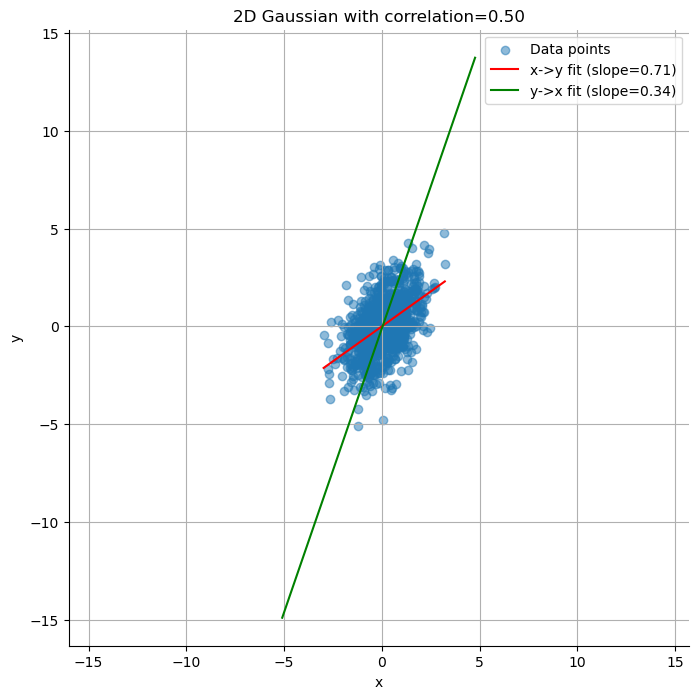

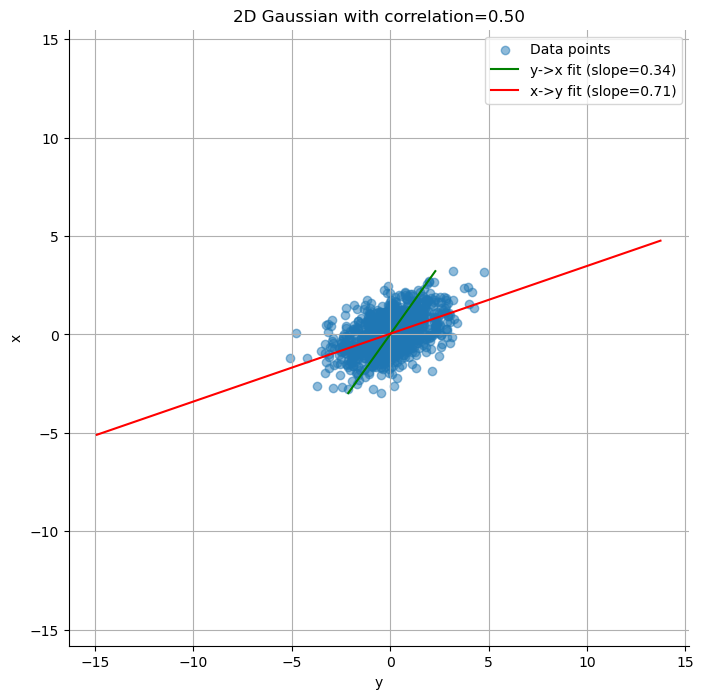

In [32]:
import math
# Generate correlated 2D Gaussian data
n_points = 1000
mean = [0, 0]
# Create covariance matrix with correlation
rho = 0.5  # correlation coefficient
nondiag = rho * math.sqrt(2)
cov = [[1, nondiag], 
       [nondiag, 2]]
data = np.random.multivariate_normal(mean, cov, n_points)

x = data[:, 0]
y = data[:, 1]

# Fit lines in both directions
slope_xy, intercept_xy, r2_xy = compute_linear_fit(x, y)
slope_yx, intercept_yx, r2_yx = compute_linear_fit(y, x)

# Plot the data and fits
plt.figure(figsize=(8,8))
plt.scatter(x, y, alpha=0.5, label='Data points')

# Plot x->y fit
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit_xy = slope_xy * x_fit + intercept_xy
plt.plot(x_fit, y_fit_xy, 'r-', label=f'x->y fit (slope={slope_xy:.2f})')

# Plot y->x fit
y_fit = np.linspace(y.min(), y.max(), 100)
x_fit_yx = slope_yx * y_fit + intercept_yx
plt.plot(y_fit, (y_fit - intercept_yx)/slope_yx, 'g-', label=f'y->x fit (slope={slope_yx:.2f})')

plt.xlabel('x')
plt.ylabel('y') 
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.title(f'2D Gaussian with correlation={rho:.2f}')
plt.show()

# make the same plot but with y on the x axis and x on the y axis
plt.figure(figsize=(8,8))
plt.scatter(y, x, alpha=0.5, label='Data points')
plt.plot(y_fit_xy, x_fit, 'g-', label=f'y->x fit (slope={slope_yx:.2f})')
plt.plot((y_fit - intercept_yx)/slope_yx, y_fit, 'r-', label=f'x->y fit (slope={slope_xy:.2f})')
plt.xlabel('y')
plt.ylabel('x')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.title(f'2D Gaussian with correlation={rho:.2f}')
plt.show()


In [13]:
channel = 1
stability_dict = {}
for channel in range(respmat1_shared.shape[1]):
    resp_x = respmat1_shared[:, channel]
    resp_y = respmat3_shared[:, channel]
    corr = np.corrcoef(resp_x, resp_y)[0,1]
    slope, intercept, R2 = compute_linear_fit(resp_x, resp_y)
    stats_dict = {
        "corr": corr,
        "slope_1to3": slope,
        "intercept_1to3": intercept,
        "R2_1to3": R2,
    }
    # print(f"Channel {channel}: slope: {slope:.2f}, intercept: {intercept:.2f}, R^2: {R2:.2f}", end="\t")
    slope, intercept, R2 = compute_linear_fit(resp_y, resp_x)
    stats_dict.update({
        "slope_3to1": slope,
        "intercept_3to1": intercept,
        "R2_3to1": R2,
    })
    # print(f"slope: {slope:.2f}, intercept: {intercept:.2f}, R^2: {R2:.2f}")
    stability_dict[channel] = stats_dict
    
stability_df = pd.DataFrame.from_dict(stability_dict, orient='index')

In [14]:
stability_df

corr  slope_1to3  intercept_1to3   R2_1to3  slope_3to1  \
0   0.837874    0.990459        0.012983  0.702033    0.708796   
1   0.633659    0.658059       -0.078581  0.401524    0.610164   
2   0.881239    0.537825        0.245543  0.776582    1.443931   
3  -0.013168   -0.028815        0.608603  0.000173   -0.006018   
4   0.892946    0.781821        0.107569  0.797353    1.019866   
..       ...         ...             ...       ...         ...   
59  0.269256    0.562799        0.277174  0.072499    0.128819   
60  0.537115    0.794481        0.145441  0.288492    0.363120   
61  0.772384    1.134007       -0.183819  0.596577    0.526079   
62  0.167872    0.363740        0.389433  0.028181    0.077476   
63  0.748674    0.700968        0.392196  0.560514    0.799627   

    intercept_3to1   R2_3to1  
0         0.320015  0.702033  
1         0.406025  0.401524  
2         0.012803  0.776582  
3         0.490269  0.000173  
4         0.059031  0.797353  
..             ...       ...  
59        0.488073  0.072499  
60        0.688599  0.288492  
61        0.338263  0.596577  
62        0.521759  0.028181  
63        0.114851  0.560513  

[64 rows x 7 columns]

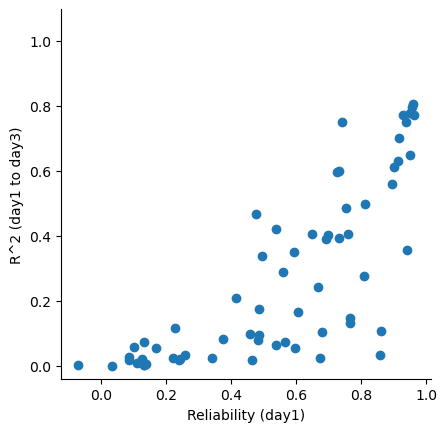

In [15]:
plt.scatter(data_dict_day1["reliability"], stability_df["R2_1to3"])
plt.xlabel("Reliability (day1)")
plt.ylabel("R^2 (day1 to day3)")
plt.axis("square")
plt.show()

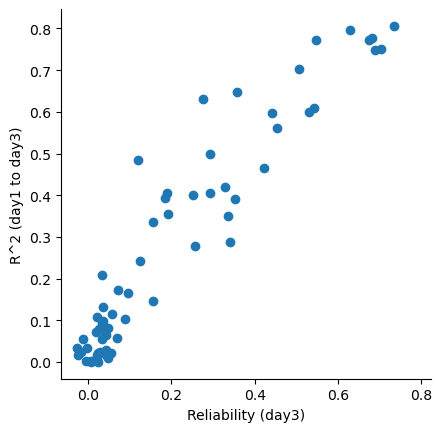

In [16]:
plt.scatter(data_dict_day3["reliability"], stability_df["R2_1to3"])
plt.xlabel("Reliability (day3)")
plt.ylabel("R^2 (day1 to day3)")
plt.axis("square")
plt.show()

In [19]:
for channel in [15,16,1,25,37,44,9]:
    print(f"Channel {channel}: within session reliability = day1 {data_dict_day1['reliability'][channel]:.2f}, day3 {data_dict_day3['reliability'][channel]:.2f}")
    print(f"Between session stability ")
    print(stability_df.loc[channel])

Channel 15: within session reliability = day1 0.94, day3 0.70
Between session stability 
corr              0.866594
slope_1to3        0.786618
intercept_1to3   -0.077411
R2_1to3           0.750986
slope_3to1        0.954702
intercept_3to1    0.272991
R2_3to1           0.750986
Name: 15, dtype: float64
Channel 16: within session reliability = day1 0.86, day3 0.02
Between session stability 
corr              0.327839
slope_1to3        0.421060
intercept_1to3    0.642472
R2_1to3           0.107478
slope_3to1        0.255256
intercept_3to1    0.441007
R2_3to1           0.107478
Name: 16, dtype: float64
Channel 1: within session reliability = day1 0.70, day3 0.25
Between session stability 
corr              0.633659
slope_1to3        0.658059
intercept_1to3   -0.078581
R2_1to3           0.401524
slope_3to1        0.610164
intercept_3to1    0.406025
R2_3to1           0.401524
Name: 1, dtype: float64
Channel 25: within session reliability = day1 0.91, day3 0.28
Between session stability 
corr

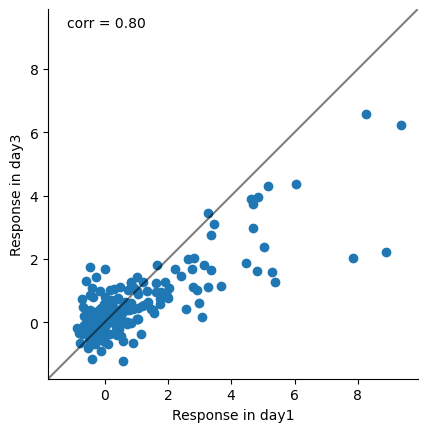

In [28]:
# Compute correlation
channel = 7
resp_x = respmat1_shared[:, channel]
resp_y = respmat3_shared[:, channel]
corr = np.corrcoef(resp_x, resp_y)[0,1]
# Get axis limits
maxval = max(resp_x.max(), resp_y.max())
minval = min(resp_x.min(), resp_y.min())
maxval = maxval + (maxval - minval)*0.05
minval = minval - (maxval - minval)*0.05
plt.scatter(resp_x, resp_y)
# plt.plot([minval, maxval], [minval, maxval], 'k--', alpha=0.5) # Add diagonal line
plt.axline(xy1=(0, 0), xy2=(1, 1), color='k', alpha=0.5)
plt.xlabel("Response in day1")
plt.ylabel("Response in day3")
plt.axis('square')  # Make axes equal
plt.xlim(minval, maxval)
plt.ylim(minval, maxval)
plt.text(0.05, 0.95, f'corr = {corr:.2f}', transform=plt.gca().transAxes)
plt.show()

### load in the prediction and test

In [25]:
import pickle as pkl
encoding_root = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs"
encoding_dir = join(encoding_root, "red_20241212-20241220")

In [26]:
pred_data_day3 = pkl.load(open(join(encoding_dir, f"population_resp_pred_{subject_id3}_RN50_RN50rbst_L4B1_Lasso_Ridge.pkl"), "rb"))
pred_data_day1 = pkl.load(open(join(encoding_dir, f"population_resp_pred_{subject_id1}_RN50_RN50rbst_L4B1_Lasso_Ridge.pkl"), "rb"))

In [30]:
pred_data_day3["resp_mat"].shape

(3420, 64)

In [ ]:
pred_data_day3["population_pred_day3_RN50_L4B1_Ridge"]

torch.Size([3420, 64])

In [38]:
# Extract information using regex for all stimuli
import re
import pandas as pd

def parse_stimulus_info(stimulus_names):
    pattern = r'(?P<model>resnet50|robust_resnet50)_(?P<method>MultiLassoCV|RidgeCV)_unit_(?P<unit>\d+)_img_(?P<img>\d+)_level_(?P<level>[-\d.]+)_score_(?P<score>[-\d.]+)\.png'
    # Initialize empty list to store matches
    matches = []
    # Go through all stimuli
    for stim in stimulus_names:
        match = re.match(pattern, stim)
        if match:
            info = match.groupdict()
            info["stimulus"] = stim
            info["accentuated"] = True
            matches.append(info)
        else:
            # For non-matching stimuli (like NSD), add None values
            matches.append({
                "stimulus": stim,
                "accentuated": False,
                'model': None,
                'method': None, 
                'unit': None,
                'img': None,
                'level': None,
                'score': None
            })

    # Convert to DataFrame
    stim_meta_df = pd.DataFrame(matches)
    # Convert numeric columns
    numeric_cols = ['level', 'score']
    for col in numeric_cols:
        stim_meta_df[col] = pd.to_numeric(stim_meta_df[col], errors='coerce').astype(float)

    # Convert unit and img to int where possible, keeping NaN values
    numeric_cols = ['unit', 'img']
    for col in numeric_cols:
        stim_meta_df[col] = pd.to_numeric(stim_meta_df[col], errors='coerce').astype('Int64') 
    print("Extracted information for all stimuli:")
    print(stim_meta_df.head())
    print(f"\nTotal rows: {len(stim_meta_df)}")
    stim_meta_df["is_nsd"] = stim_meta_df['stimulus'].str.contains('nsd')
    stim_meta_df["is_controversial"] = stim_meta_df['stimulus'].str.contains('controversial')
    # assert that there is no controversial or nsd in the accentuated stimuli
    assert stim_meta_df.query('not (accentuated or is_controversial or is_nsd)').empty
    return stim_meta_df


def parse_controversial_stimuli(stim_meta_df):
    # Pattern to match controversial image filenames
    controversial_pattern = r'controversial_max_(?P<model>r50|robust)_(?P<method>MultiLassoCV)_unit_(?P<unit>\d+)_img_(?P<img>\d+)_srobust_(?P<score_robust>[-\d.]+)_sr50_(?P<score_r50>[-\d.]+)\.png'

    # Initialize empty list to store matches
    controversial_matches = []

    # Go through controversial stimuli
    controversial_stimuli = stim_meta_df.query("is_controversial").stimulus.values
    for stim in controversial_stimuli:
        match = re.match(controversial_pattern, stim)
        if match:
            info = match.groupdict()
            info["stimulus"] = stim
            controversial_matches.append(info)
        else:
            print(f"No match found for controversial stimulus: {stim}")

    # Convert to DataFrame
    controversial_df = pd.DataFrame(controversial_matches)

    # Convert numeric columns
    numeric_cols = ['score_robust', 'score_r50',]
    for col in numeric_cols:
        controversial_df[col] = pd.to_numeric(controversial_df[col], errors='coerce')
    numeric_cols = ['unit', 'img']
    for col in numeric_cols:
        controversial_df[col] = pd.to_numeric(controversial_df[col], errors='coerce').astype('Int64')

    # Print first few rows to verify parsing
    print("Extracted information from controversial stimuli:")
    print(controversial_df.head())
    print(f"\nTotal controversial stimuli parsed: {len(controversial_df)}")
    return controversial_df

In [40]:
stim_meta_df = parse_stimulus_info(pred_data_day3["stimulus_names"])
controversial_df = parse_controversial_stimuli(stim_meta_df)
stim_contrv_meta_df = stim_meta_df.fillna(controversial_df).merge(controversial_df[["stimulus", "score_robust", "score_r50", ]], on="stimulus", how="outer")

Extracted information for all stimuli:
                                            stimulus  accentuated model  \
0  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
1  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
2  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
3  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
4  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   

  method  unit   img  level  score  
0   None  <NA>  <NA>    NaN    NaN  
1   None  <NA>  <NA>    NaN    NaN  
2   None  <NA>  <NA>    NaN    NaN  
3   None  <NA>  <NA>    NaN    NaN  
4   None  <NA>  <NA>    NaN    NaN  

Total rows: 3420
Extracted information from controversial stimuli:
  model        method  unit  img  score_robust  score_r50  \
0   r50  MultiLassoCV    15    0     -0.394836  10.820349   
1   r50  MultiLassoCV    15    1     -0.322991  11.145054   
2   r50  MultiLassoCV    15    2     

In [41]:
stim_contrv_meta_df

stimulus  accentuated model  \
0     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
1     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
2     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
3     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
4     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
...                                                 ...          ...   ...   
3415                            shared0508_nsd38495.png        False   NaN   
3416                            shared0560_nsd42215.png        False   NaN   
3417                            shared0631_nsd46161.png        False   NaN   
3418                            shared0862_nsd62480.png        False   NaN   
3419                            shared0974_nsd70506.png        False   NaN   

            method  unit   img  level  score  is_nsd  is_controversial  \
0     MultiLassoCV    15     0    NaN    NaN   False              True   
1     MultiLassoCV    15     1    NaN    NaN   False              True   
2     MultiLassoCV    15     2    NaN    NaN   False              True   
3     MultiLassoCV    15     3    NaN    NaN   False              True   
4     MultiLassoCV    15     4    NaN    NaN   False              True   
...            ...   ...   ...    ...    ...     ...               ...   
3415           NaN  <NA>  <NA>    NaN    NaN    True             False   
3416           NaN  <NA>  <NA>    NaN    NaN    True             False   
3417           NaN  <NA>  <NA>    NaN    NaN    True             False   
3418           NaN  <NA>  <NA>    NaN    NaN    True             False   
3419           NaN  <NA>  <NA>    NaN    NaN    True             False   

      score_robust  score_r50  
0        -0.394836  10.820349  
1        -0.322991  11.145054  
2        -0.555082  11.866060  
3        -0.861608  10.422665  
4        -0.915930   9.685411  
...            ...        ...  
3415           NaN        NaN  
3416           NaN        NaN  
3417           NaN        NaN  
3418           NaN        NaN  
3419           NaN        NaN  

[3420 rows x 12 columns]

In [45]:
part_df = stim_contrv_meta_df.query("accentuated and model == 'robust_resnet50' and method == 'RidgeCV' and unit == 44")
stim_idxs = part_df.index

In [ ]:
pred_data_day3["resp_mat"].shape
pred_data_day3["population_pred_day3_RN50rbst_L4B1_Ridge"]

In [55]:
stability_df.loc[44]

corr              0.897868
slope_1to3        0.602355
intercept_1to3   -0.230623
R2_1to3           0.806167
slope_3to1        1.338359
intercept_3to1    0.562132
R2_3to1           0.806167
Name: 44, dtype: float64

In [66]:
def compute_correlation(resp_actual, resp_pred):
    return np.corrcoef(resp_actual, resp_pred)[0,1]


def compute_r2(resp_actual, resp_pred):
    ss_res = np.sum((resp_actual - resp_pred) ** 2)
    ss_tot = np.sum((resp_actual - np.mean(resp_actual)) ** 2)
    return 1 - ss_res / ss_tot


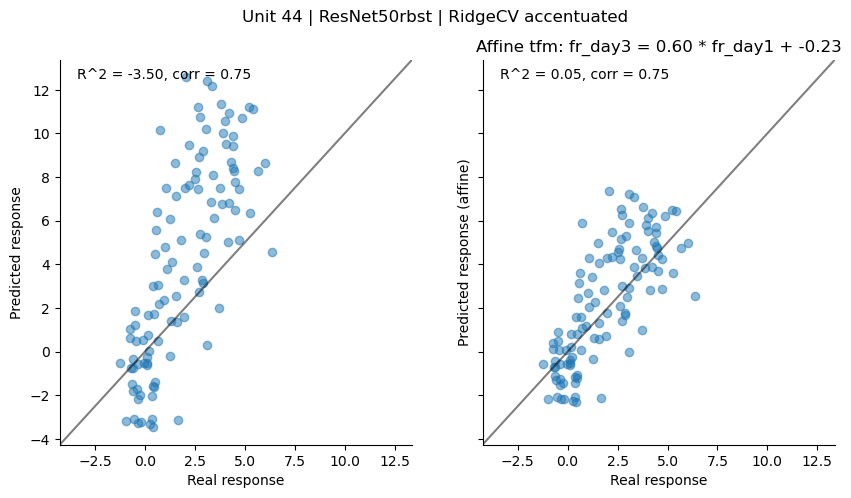

In [71]:
channel = 44
part_df = stim_contrv_meta_df.query("accentuated and model == 'robust_resnet50' and method == 'RidgeCV' and unit == @channel")
stim_idxs = part_df.index
resp_actual = pred_data_day3["resp_mat"][stim_idxs, channel]
resp_pred = pred_data_day3["population_pred_day3_RN50rbst_L4B1_Ridge"][stim_idxs, channel]
resp_pred_affine = resp_pred * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]

figh, axs = plt.subplots(1, 2, figsize=(10, 5), sharex="row", sharey="row")
plt.sca(axs[0])
plt.scatter(resp_actual, resp_pred, alpha=0.5)
R2 = compute_r2(resp_actual, resp_pred.numpy())
corr = compute_correlation(resp_actual, resp_pred)
plt.text(0.05, 0.95, f'R^2 = {R2:.2f}, corr = {corr:.2f}', transform=plt.gca().transAxes)
plt.axline(xy1=(0, 0), xy2=(1, 1), color='k', alpha=0.5)
plt.xlabel("Real response")
plt.ylabel("Predicted response")
# make x, y share the same range
LIM = (min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1]))
plt.xlim(LIM)
plt.ylim(LIM)
# plt.axis('equal')  # Make axes equal scale
plt.sca(axs[1])
plt.scatter(resp_actual, resp_pred_affine, alpha=0.5)
R2 = compute_r2(resp_actual, resp_pred_affine.numpy())
corr = compute_correlation(resp_actual, resp_pred_affine)
plt.text(0.05, 0.95, f'R^2 = {R2:.2f}, corr = {corr:.2f}', transform=plt.gca().transAxes)
plt.axline(xy1=(0, 0), xy2=(1, 1), color='k', alpha=0.5)
LIM = (min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1]))
plt.xlim(LIM)
plt.ylim(LIM)
plt.xlabel("Real response")
plt.ylabel("Predicted response (affine)")
plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
# plt.axis('equal')  # Make axes equal scale
plt.suptitle(f"Unit {channel} | ResNet50rbst | RidgeCV accentuated")
plt.show()

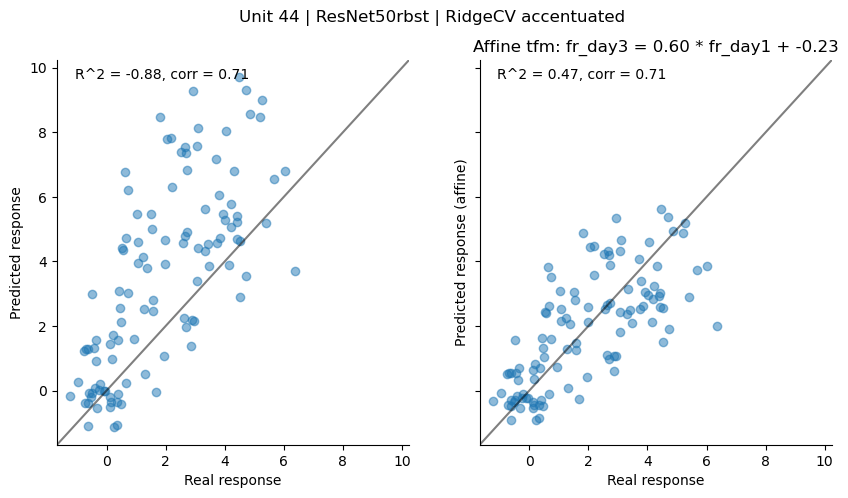

In [74]:
channel = 44
part_df = stim_contrv_meta_df.query("accentuated and model == 'robust_resnet50' and method == 'RidgeCV' and unit == @channel")
stim_idxs = part_df.index
resp_actual = pred_data_day3["resp_mat"][stim_idxs, channel]
resp_pred = pred_data_day3["population_pred_day3_RN50_L4B1_Ridge"][stim_idxs, channel]
resp_pred_affine = resp_pred * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]

figh, axs = plt.subplots(1, 2, figsize=(10, 5), sharex="row", sharey="row")
plt.sca(axs[0])
plt.scatter(resp_actual, resp_pred, alpha=0.5)
R2 = compute_r2(resp_actual, resp_pred.numpy())
corr = compute_correlation(resp_actual, resp_pred)
plt.text(0.05, 0.95, f'R^2 = {R2:.2f}, corr = {corr:.2f}', transform=plt.gca().transAxes)
plt.axline(xy1=(0, 0), xy2=(1, 1), color='k', alpha=0.5)
plt.xlabel("Real response")
plt.ylabel("Predicted response")
# make x, y share the same range
LIM = (min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1]))
plt.xlim(LIM)
plt.ylim(LIM)
# plt.axis('equal')  # Make axes equal scale
plt.sca(axs[1])
plt.scatter(resp_actual, resp_pred_affine, alpha=0.5)
R2 = compute_r2(resp_actual, resp_pred_affine.numpy())
corr = compute_correlation(resp_actual, resp_pred_affine)
plt.text(0.05, 0.95, f'R^2 = {R2:.2f}, corr = {corr:.2f}', transform=plt.gca().transAxes)
plt.axline(xy1=(0, 0), xy2=(1, 1), color='k', alpha=0.5)
LIM = (min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1]))
plt.xlim(LIM)
plt.ylim(LIM)
plt.xlabel("Real response")
plt.ylabel("Predicted response (affine)")
plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
# plt.axis('equal')  # Make axes equal scale
plt.suptitle(f"Unit {channel} | ResNet50rbst | RidgeCV accentuated")
plt.show()

In [96]:
def annotate_scatter(ax, resp_actual, resp_pred):
    if isinstance(resp_actual, torch.Tensor):
        resp_actual = resp_actual.numpy()
    if isinstance(resp_pred, torch.Tensor):
        resp_pred = resp_pred.numpy()
    R2 = compute_r2(resp_actual, resp_pred)
    corr = compute_correlation(resp_actual, resp_pred)
    ax.text(0.05, 0.95, f'R^2 = {R2:.2f}, corr = {corr:.2f}', transform=ax.transAxes)
    ax.axline(xy1=(0, 0), xy2=(1, 1), color='k', alpha=0.5)
    LIM = (min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]))
    ax.set_xlim(LIM)
    ax.set_ylim(LIM)
    return R2, corr

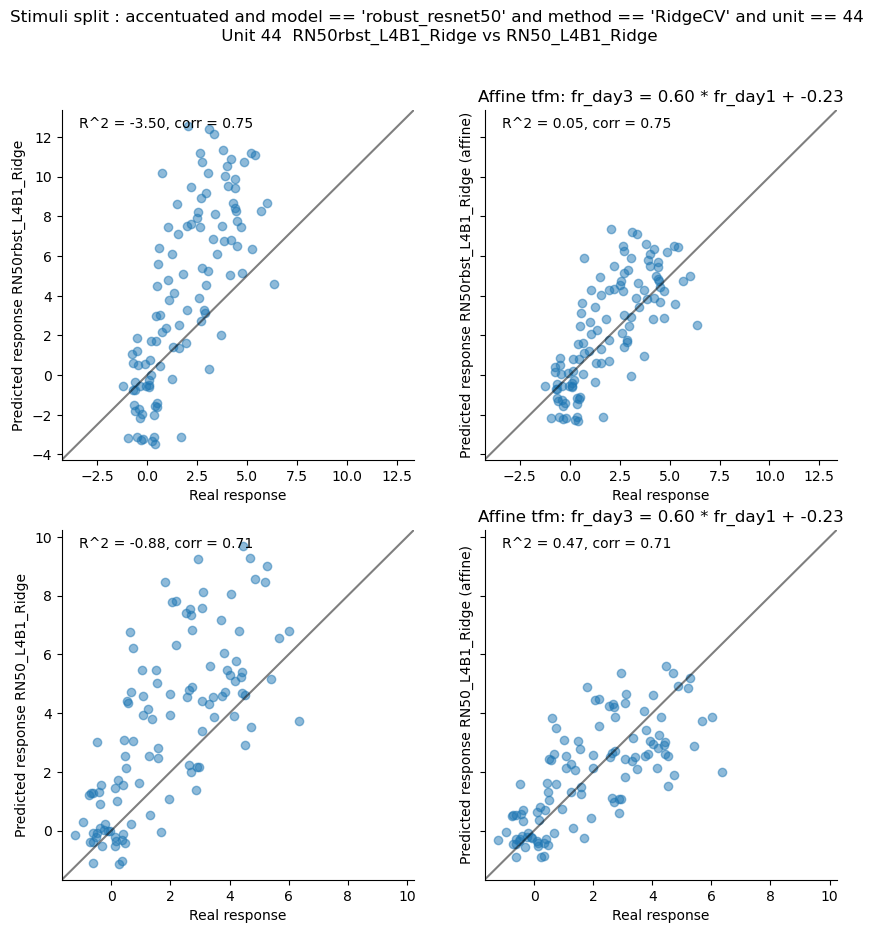

In [80]:
channel = 44
split_str = f"accentuated and model == 'robust_resnet50' and method == 'RidgeCV' and unit == {channel}"
part_df = stim_contrv_meta_df.query(split_str)
stim_idxs = part_df.index
resp_actual = pred_data_day3["resp_mat"][stim_idxs, channel]
modelname1 = "RN50rbst_L4B1_Ridge"
modelname2 = "RN50_L4B1_Ridge"
resp_pred1 = pred_data_day3["population_pred_day3_RN50rbst_L4B1_Ridge"][stim_idxs, channel]
resp_pred2 = pred_data_day3["population_pred_day3_RN50_L4B1_Ridge"][stim_idxs, channel]
resp_pred1_affine = resp_pred1 * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]
resp_pred2_affine = resp_pred2 * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]

figh, axs = plt.subplots(2, 2, figsize=(10, 10), sharex="row", sharey="row")
plt.sca(axs[0,0])
plt.scatter(resp_actual, resp_pred1, alpha=0.5)
annotate_scatter(axs[0,0], resp_actual, resp_pred1)
plt.xlabel("Real response")
plt.ylabel(f"Predicted response {modelname1}")
plt.sca(axs[0,1])
plt.scatter(resp_actual, resp_pred1_affine, alpha=0.5)
annotate_scatter(axs[0,1], resp_actual, resp_pred1_affine)
plt.xlabel("Real response")
plt.ylabel(f"Predicted response {modelname1} (affine)")
plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
plt.sca(axs[1,0])
plt.scatter(resp_actual, resp_pred2, alpha=0.5)
annotate_scatter(axs[1,0], resp_actual, resp_pred2)
plt.xlabel("Real response")
plt.ylabel(f"Predicted response {modelname2}")
plt.sca(axs[1,1])
plt.scatter(resp_actual, resp_pred2_affine, alpha=0.5)
annotate_scatter(axs[1,1], resp_actual, resp_pred2_affine)
plt.xlabel("Real response")
plt.ylabel(f"Predicted response {modelname2} (affine)")
plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
plt.suptitle(f"Stimuli split : {split_str}\n Unit {channel}  {modelname1} vs {modelname2}")
plt.show()

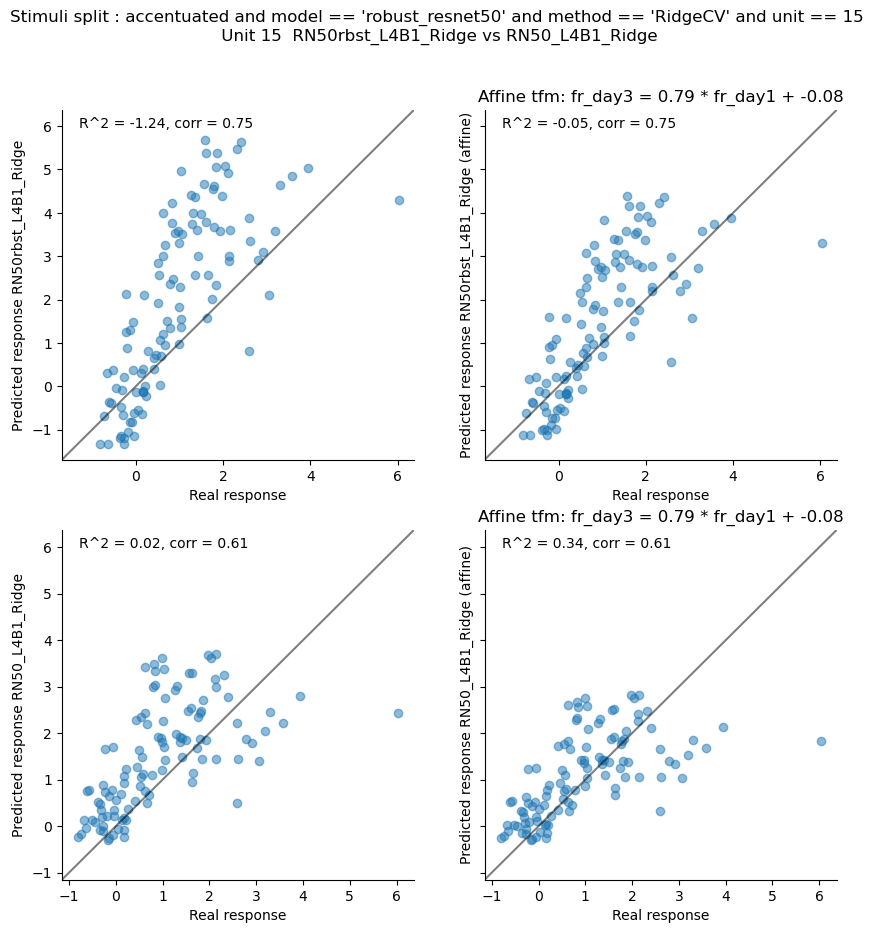

In [81]:
channel = 15
split_str = f"accentuated and model == 'robust_resnet50' and method == 'RidgeCV' and unit == {channel}"
part_df = stim_contrv_meta_df.query(split_str)
stim_idxs = part_df.index
resp_actual = pred_data_day3["resp_mat"][stim_idxs, channel]
modelname1 = "RN50rbst_L4B1_Ridge"
modelname2 = "RN50_L4B1_Ridge"
resp_pred1 = pred_data_day3["population_pred_day3_RN50rbst_L4B1_Ridge"][stim_idxs, channel]
resp_pred2 = pred_data_day3["population_pred_day3_RN50_L4B1_Ridge"][stim_idxs, channel]
resp_pred1_affine = resp_pred1 * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]
resp_pred2_affine = resp_pred2 * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]

figh, axs = plt.subplots(2, 2, figsize=(10, 10), sharex="row", sharey="row")
plt.sca(axs[0,0])
plt.scatter(resp_actual, resp_pred1, alpha=0.5)
annotate_scatter(axs[0,0], resp_actual, resp_pred1)
plt.xlabel("Real response")
plt.ylabel(f"Predicted response {modelname1}")
plt.sca(axs[0,1])
plt.scatter(resp_actual, resp_pred1_affine, alpha=0.5)
annotate_scatter(axs[0,1], resp_actual, resp_pred1_affine)
plt.xlabel("Real response")
plt.ylabel(f"Predicted response {modelname1} (affine)")
plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
plt.sca(axs[1,0])
plt.scatter(resp_actual, resp_pred2, alpha=0.5)
annotate_scatter(axs[1,0], resp_actual, resp_pred2)
plt.xlabel("Real response")
plt.ylabel(f"Predicted response {modelname2}")
plt.sca(axs[1,1])
plt.scatter(resp_actual, resp_pred2_affine, alpha=0.5)
annotate_scatter(axs[1,1], resp_actual, resp_pred2_affine)
plt.xlabel("Real response")
plt.ylabel(f"Predicted response {modelname2} (affine)")
plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
plt.suptitle(f"Stimuli split : {split_str}\n Unit {channel}  {modelname1} vs {modelname2}")
plt.show()

In [82]:
stim_contrv_meta_df.unit.unique()

<IntegerArray>
[15, 16, 1, 25, 37, 44, 9, <NA>]
Length: 8, dtype: Int64

In [88]:
part_df.columns

Index(['stimulus', 'accentuated', 'model', 'method', 'unit', 'img', 'level',
       'score', 'is_nsd', 'is_controversial', 'score_robust', 'score_r50'],
      dtype='object')

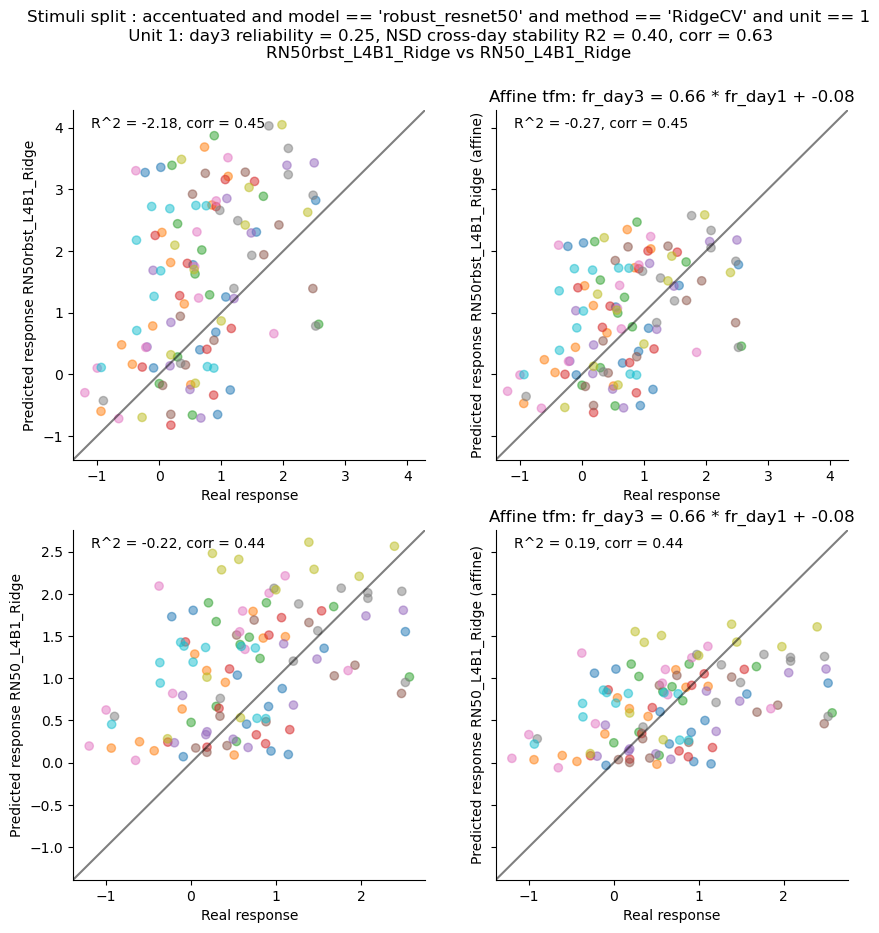

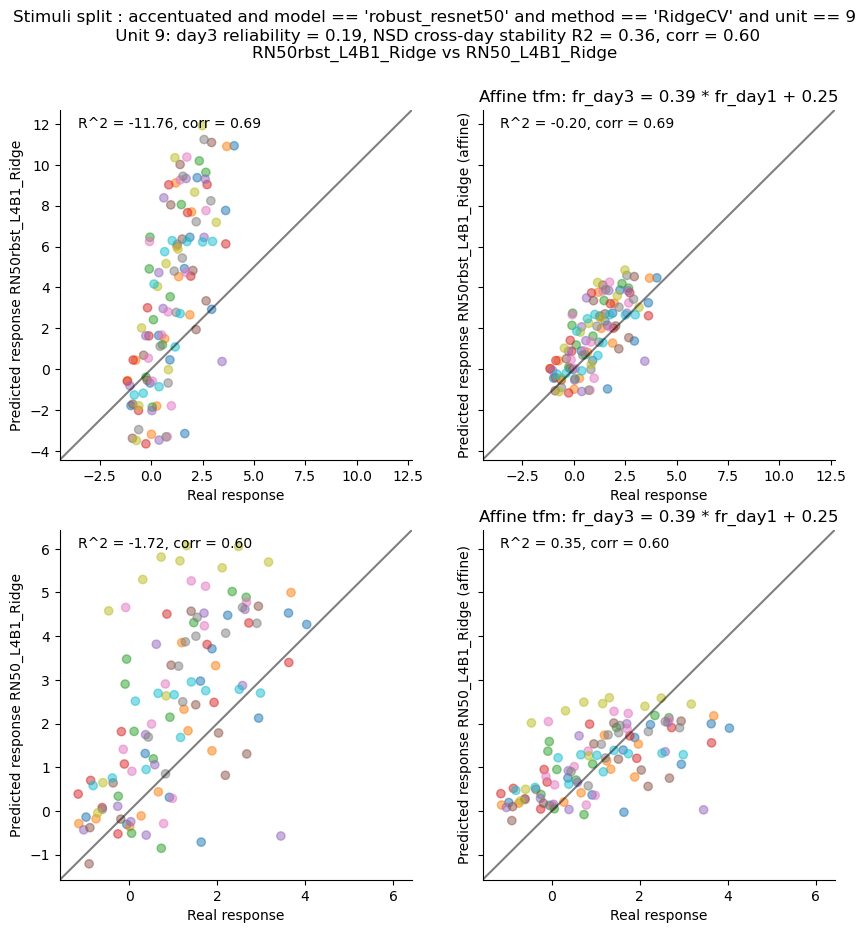

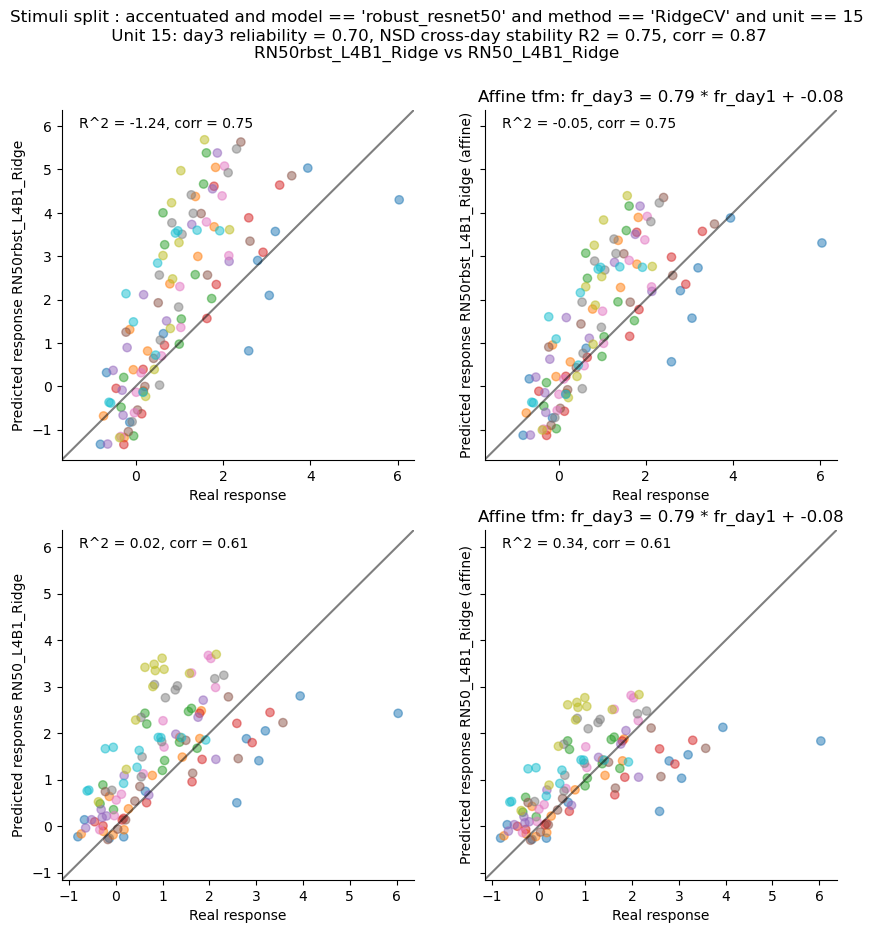

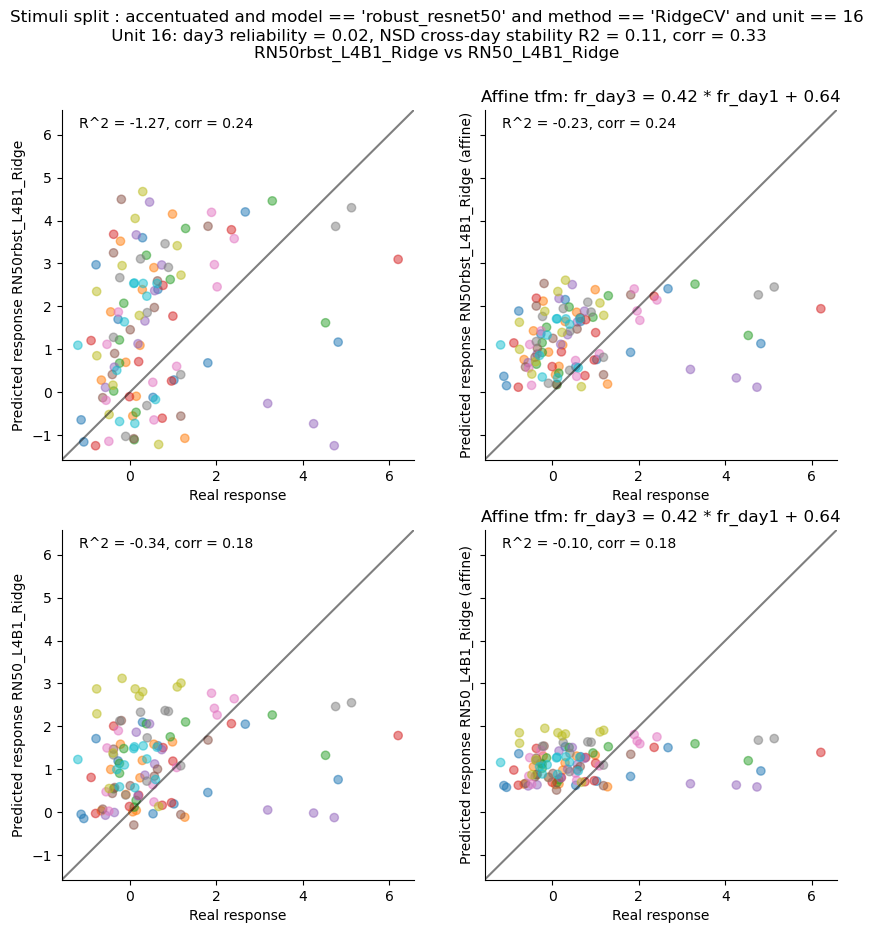

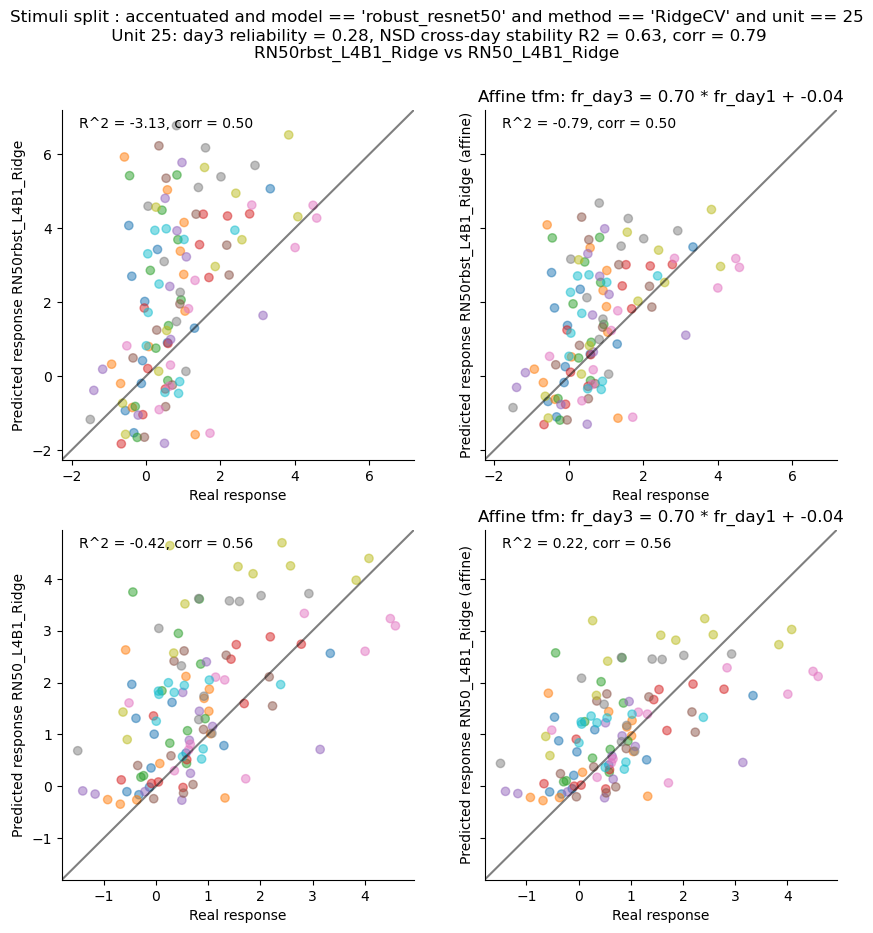

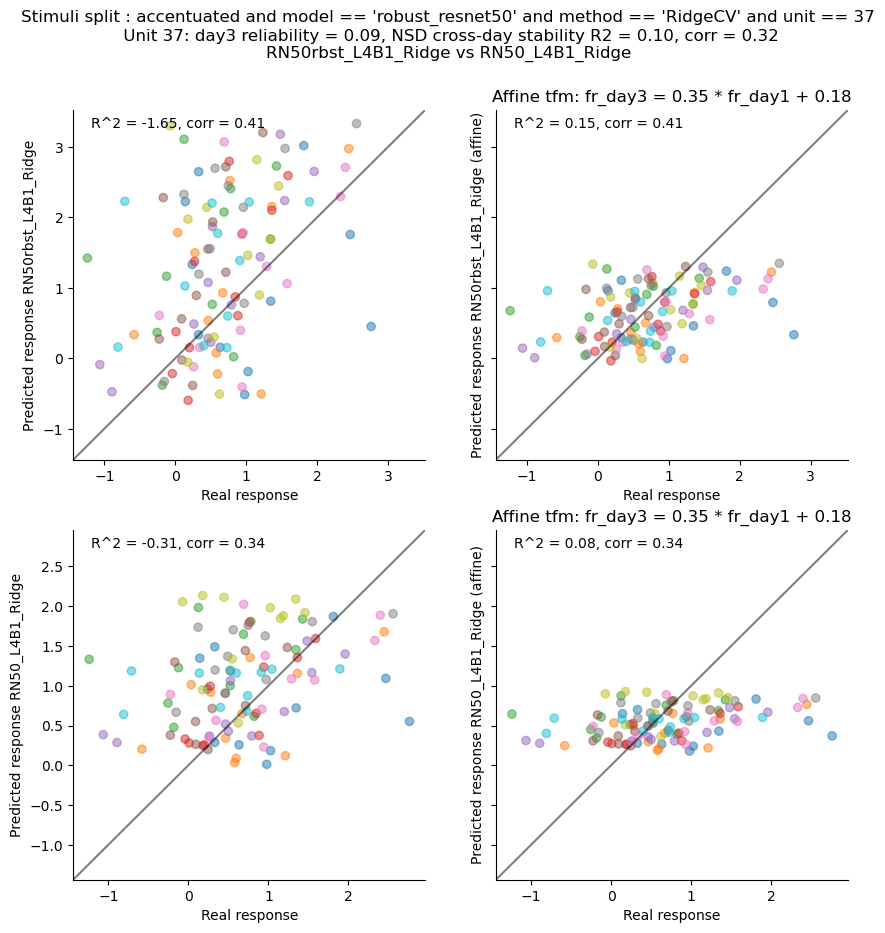

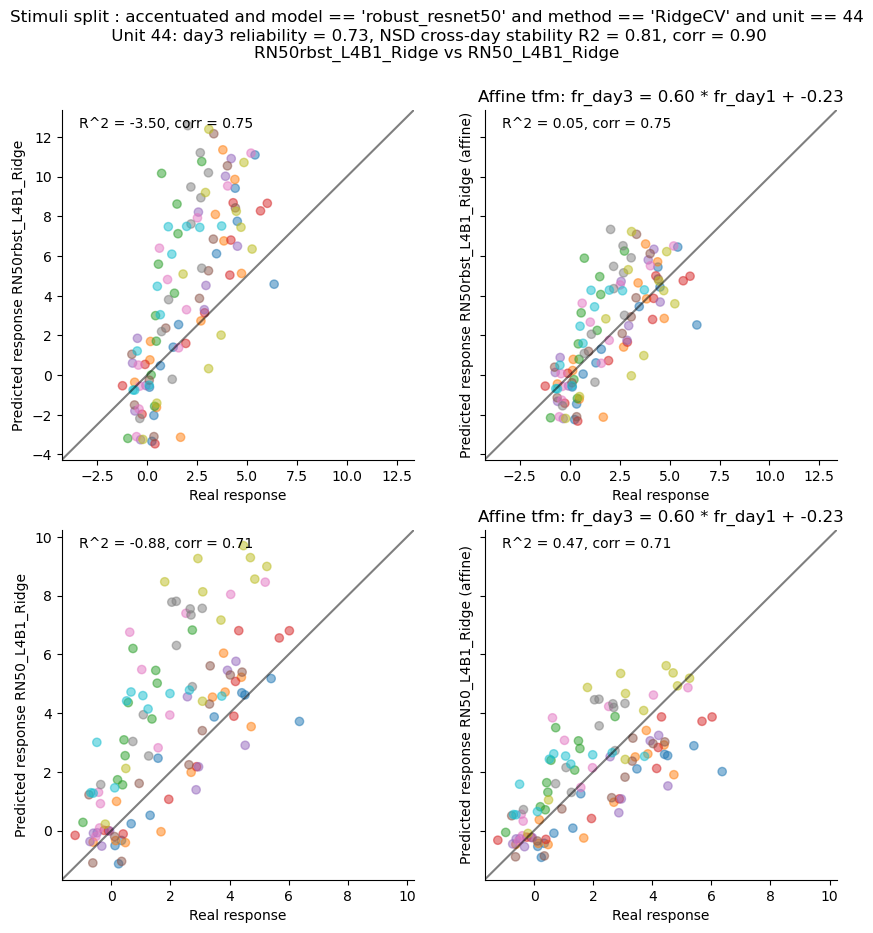

In [90]:
for channel in [1, 9, 15, 16, 25, 37, 44, ]:
    split_str = f"accentuated and model == 'robust_resnet50' and method == 'RidgeCV' and unit == {channel}"
    part_df = stim_contrv_meta_df.query(split_str)
    stim_idxs = part_df.index
    resp_actual = pred_data_day3["resp_mat"][stim_idxs, channel]
    image_seed = part_df.img
    modelname1 = "RN50rbst_L4B1_Ridge"
    modelname2 = "RN50_L4B1_Ridge"
    resp_pred1 = pred_data_day3["population_pred_day3_RN50rbst_L4B1_Ridge"][stim_idxs, channel]
    resp_pred2 = pred_data_day3["population_pred_day3_RN50_L4B1_Ridge"][stim_idxs, channel]
    resp_pred1_affine = resp_pred1 * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]
    resp_pred2_affine = resp_pred2 * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]
    reliability = data_dict_day3['reliability'][channel]
    stability_R2 = stability_df.loc[channel, "R2_1to3"]
    stability_corr = stability_df.loc[channel, "corr"]

    figh, axs = plt.subplots(2, 2, figsize=(10, 10), sharex="row", sharey="row")
    plt.sca(axs[0,0])
    plt.scatter(resp_actual, resp_pred1, c=image_seed, alpha=0.5, cmap='tab10')
    annotate_scatter(axs[0,0], resp_actual, resp_pred1)
    plt.xlabel("Real response")
    plt.ylabel(f"Predicted response {modelname1}")
    plt.sca(axs[0,1])
    plt.scatter(resp_actual, resp_pred1_affine, c=image_seed, alpha=0.5, cmap='tab10')
    annotate_scatter(axs[0,1], resp_actual, resp_pred1_affine)
    plt.xlabel("Real response")
    plt.ylabel(f"Predicted response {modelname1} (affine)")
    plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
    plt.sca(axs[1,0])
    plt.scatter(resp_actual, resp_pred2, c=image_seed, alpha=0.5, cmap='tab10')
    annotate_scatter(axs[1,0], resp_actual, resp_pred2)
    plt.xlabel("Real response")
    plt.ylabel(f"Predicted response {modelname2}")
    plt.sca(axs[1,1])
    plt.scatter(resp_actual, resp_pred2_affine, c=image_seed, alpha=0.5, cmap='tab10')
    annotate_scatter(axs[1,1], resp_actual, resp_pred2_affine)
    plt.xlabel("Real response")
    plt.ylabel(f"Predicted response {modelname2} (affine)")
    plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
    plt.suptitle(f"Stimuli split : {split_str}\n Unit {channel}: day3 reliability = {reliability:.2f}, NSD cross-day stability R2 = {stability_R2:.2f}, corr = {stability_corr:.2f}\n{modelname1} vs {modelname2}")
    plt.show()

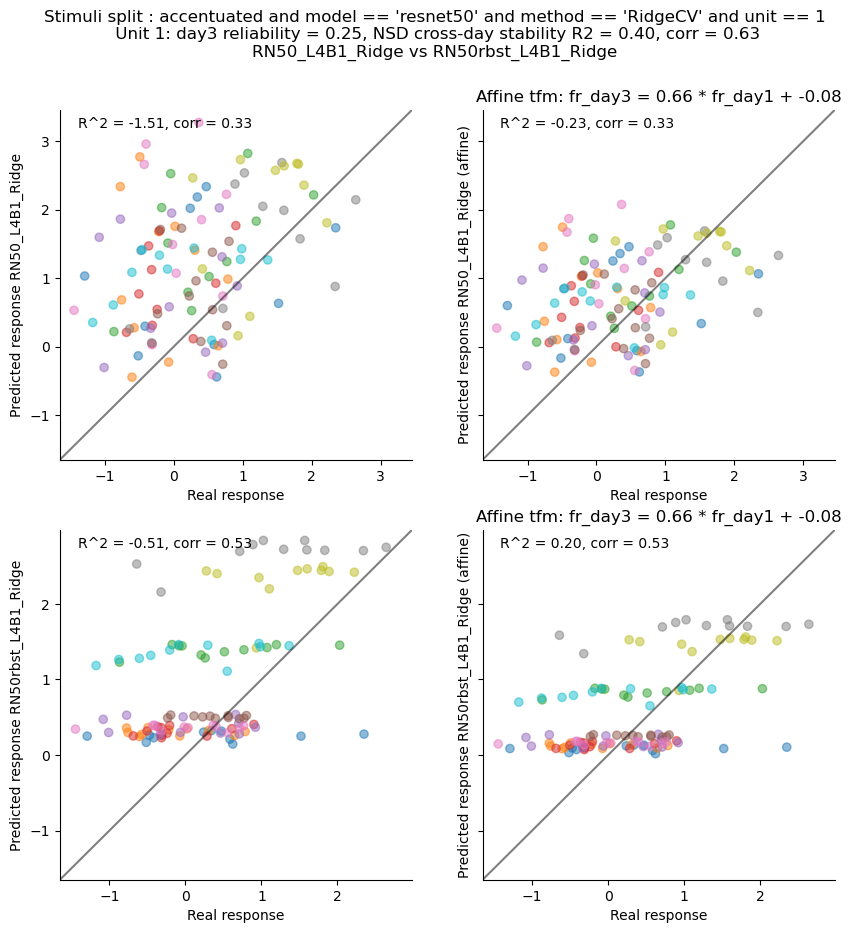

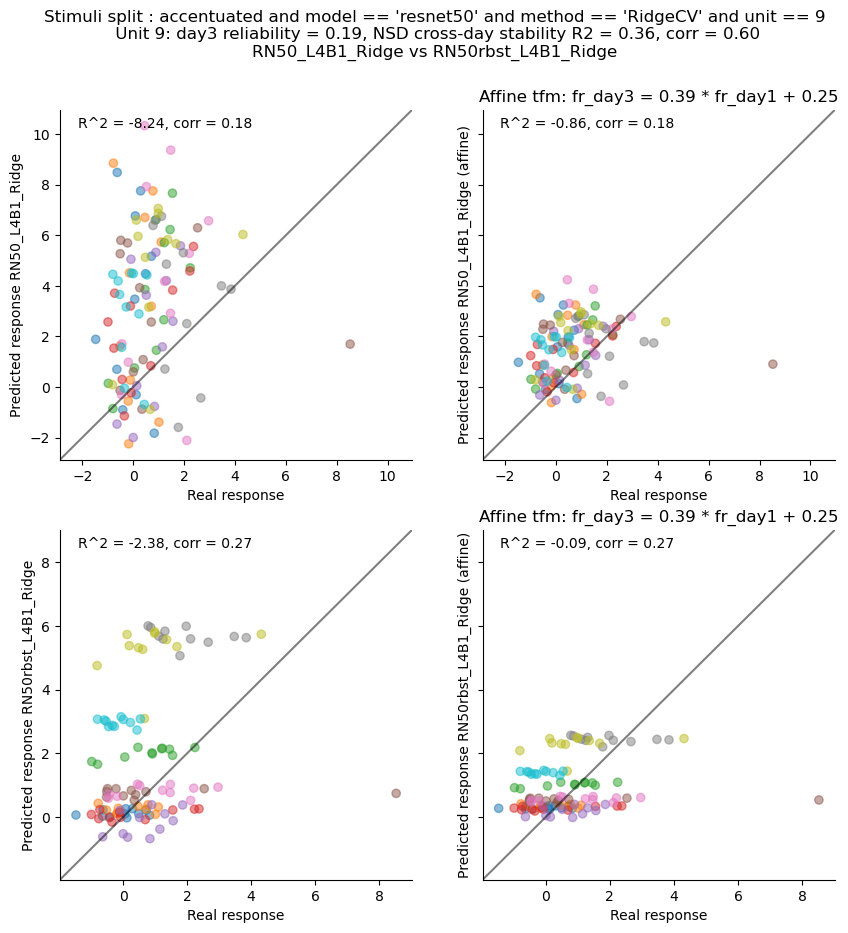

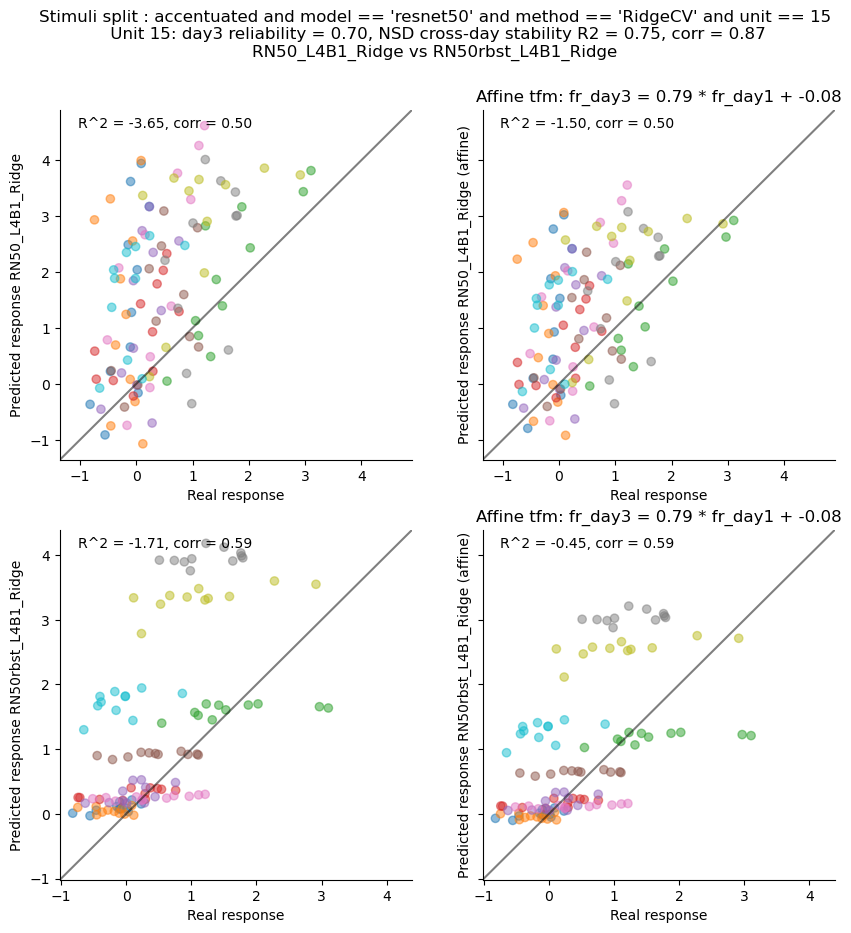

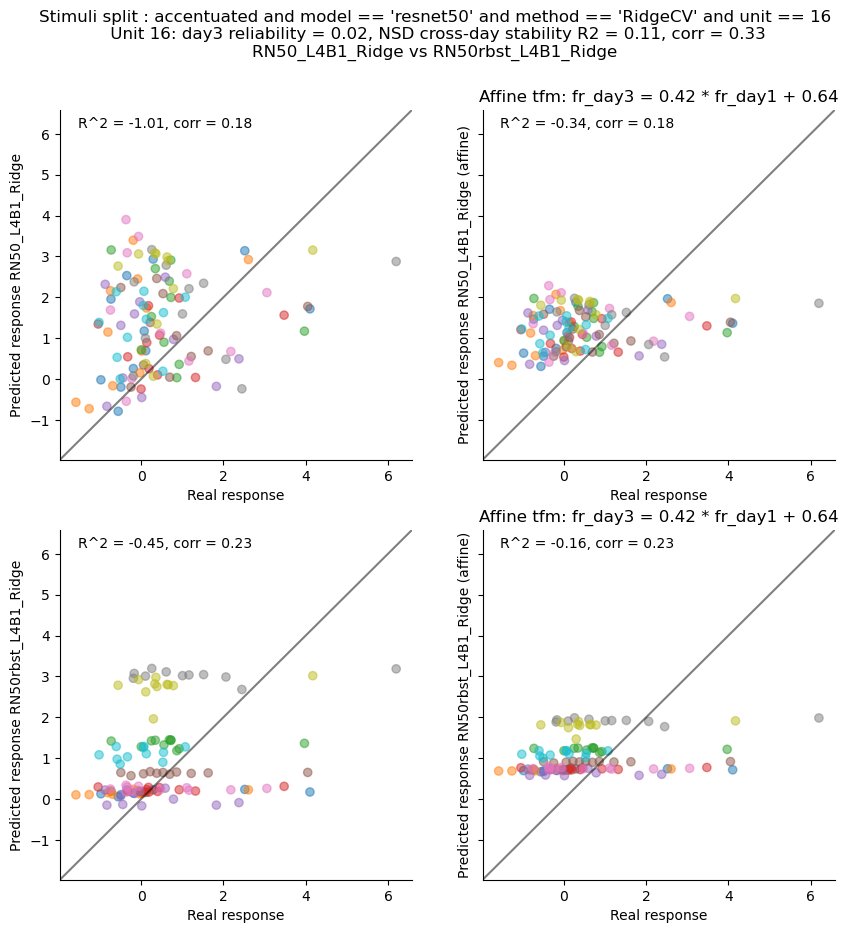

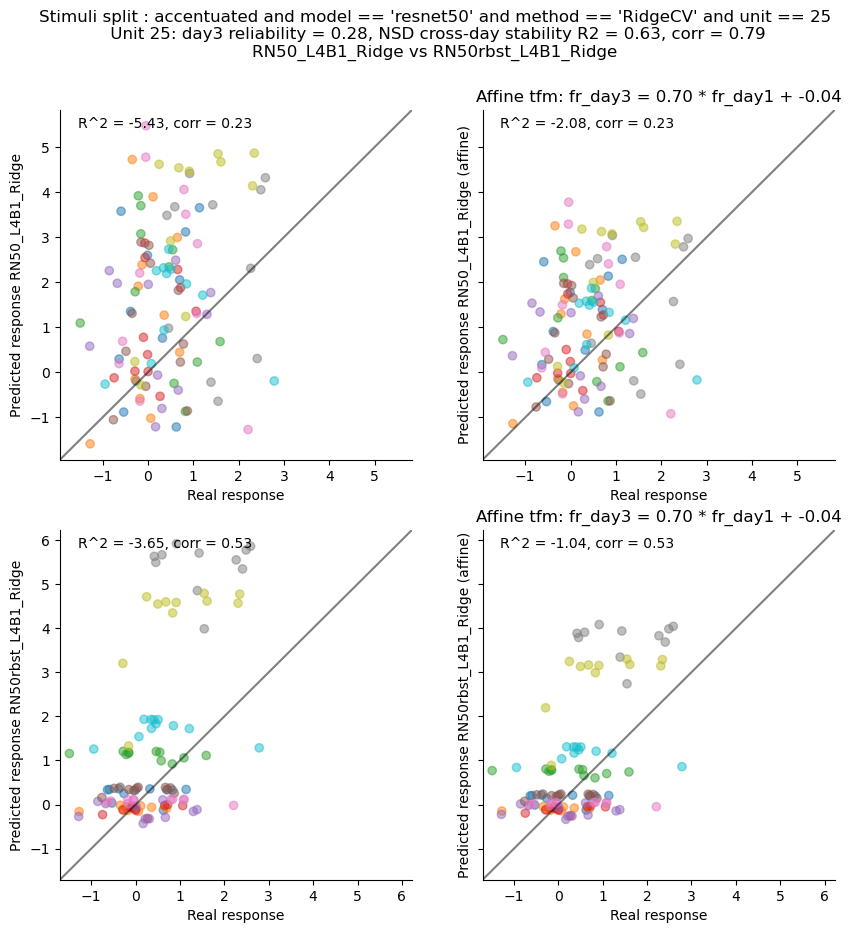

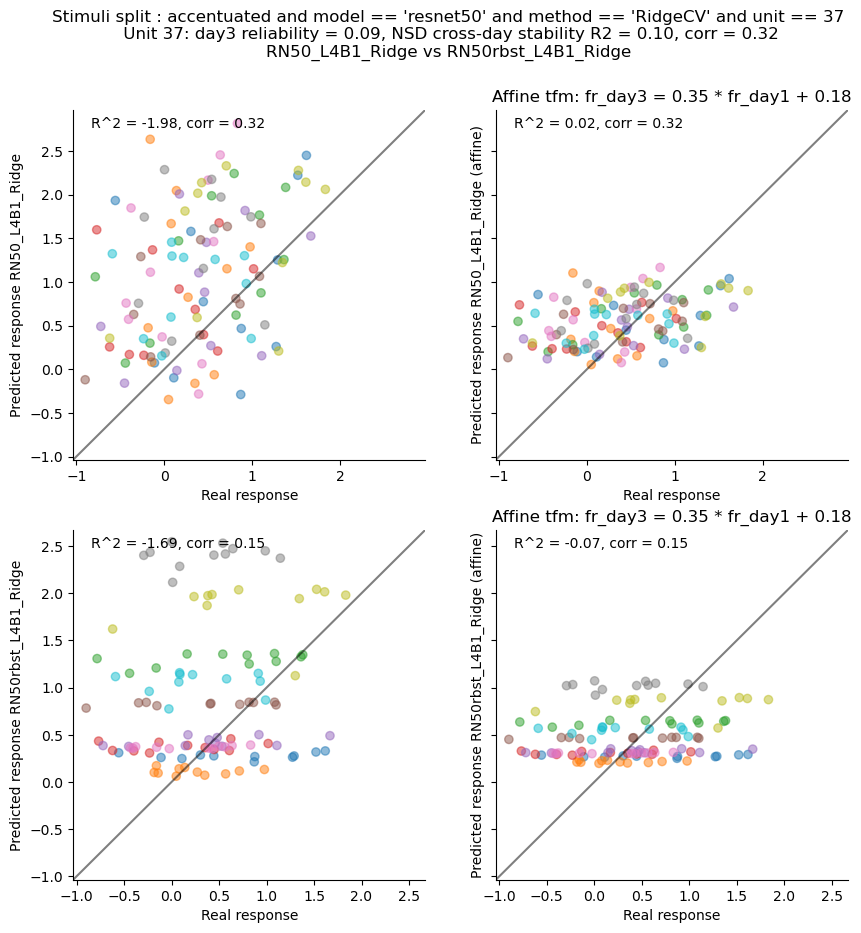

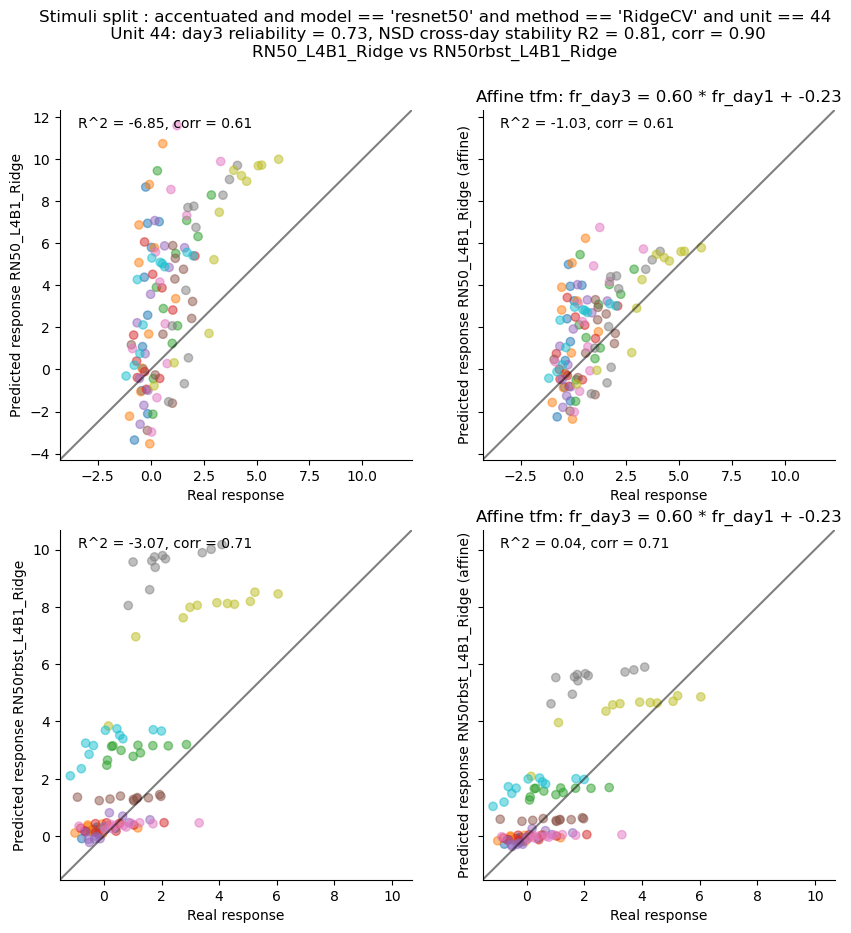

In [92]:
for channel in [1, 9, 15, 16, 25, 37, 44, ]:
    split_str = f"accentuated and model == 'resnet50' and method == 'RidgeCV' and unit == {channel}"
    part_df = stim_contrv_meta_df.query(split_str)
    stim_idxs = part_df.index
    resp_actual = pred_data_day3["resp_mat"][stim_idxs, channel]
    image_seed = part_df.img
    modelname1 = "RN50_L4B1_Ridge"
    modelname2 = "RN50rbst_L4B1_Ridge"
    resp_pred1 = pred_data_day3["population_pred_day3_RN50_L4B1_Ridge"][stim_idxs, channel]
    resp_pred2 = pred_data_day3["population_pred_day3_RN50rbst_L4B1_Ridge"][stim_idxs, channel]
    resp_pred1_affine = resp_pred1 * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]
    resp_pred2_affine = resp_pred2 * stability_df.loc[channel, "slope_1to3"] + stability_df.loc[channel, "intercept_1to3"]
    reliability = data_dict_day3['reliability'][channel]
    stability_R2 = stability_df.loc[channel, "R2_1to3"]
    stability_corr = stability_df.loc[channel, "corr"]

    figh, axs = plt.subplots(2, 2, figsize=(10, 10), sharex="row", sharey="row")
    plt.sca(axs[0,0])
    plt.scatter(resp_actual, resp_pred1, c=image_seed, alpha=0.5, cmap='tab10')
    annotate_scatter(axs[0,0], resp_actual, resp_pred1)
    plt.xlabel("Real response")
    plt.ylabel(f"Predicted response {modelname1}")
    plt.sca(axs[0,1])
    plt.scatter(resp_actual, resp_pred1_affine, c=image_seed, alpha=0.5, cmap='tab10')
    annotate_scatter(axs[0,1], resp_actual, resp_pred1_affine)
    plt.xlabel("Real response")
    plt.ylabel(f"Predicted response {modelname1} (affine)")
    plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
    plt.sca(axs[1,0])
    plt.scatter(resp_actual, resp_pred2, c=image_seed, alpha=0.5, cmap='tab10')
    annotate_scatter(axs[1,0], resp_actual, resp_pred2)
    plt.xlabel("Real response")
    plt.ylabel(f"Predicted response {modelname2}")
    plt.sca(axs[1,1])
    plt.scatter(resp_actual, resp_pred2_affine, c=image_seed, alpha=0.5, cmap='tab10')
    annotate_scatter(axs[1,1], resp_actual, resp_pred2_affine)
    plt.xlabel("Real response")
    plt.ylabel(f"Predicted response {modelname2} (affine)")
    plt.title(f"Affine tfm: fr_day3 = {stability_df.loc[channel, 'slope_1to3']:.2f} * fr_day1 + {stability_df.loc[channel, 'intercept_1to3']:.2f}")
    plt.suptitle(f"Stimuli split : {split_str}\n Unit {channel}: day3 reliability = {reliability:.2f}, NSD cross-day stability R2 = {stability_R2:.2f}, corr = {stability_corr:.2f}\n{modelname1} vs {modelname2}")
    plt.show()

/tmp/ipykernel_3021869/2306735241.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(resp_actual_day1, resp_actual_day3, alpha=0.5, cmap='tab10')


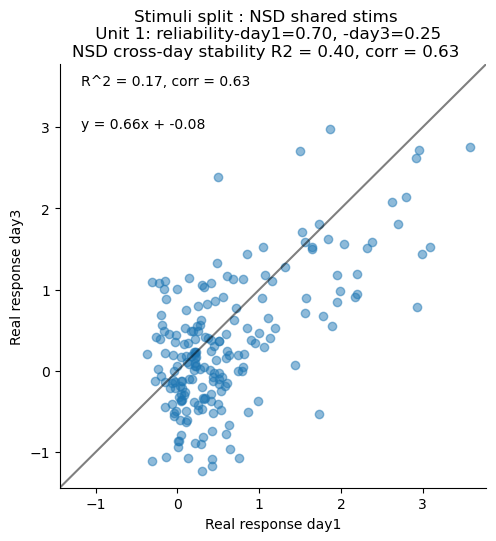

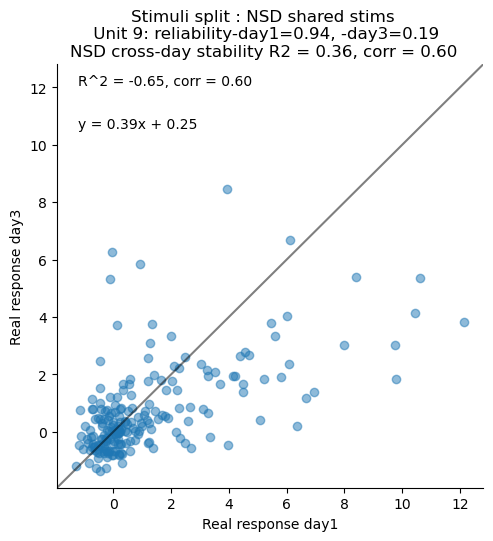

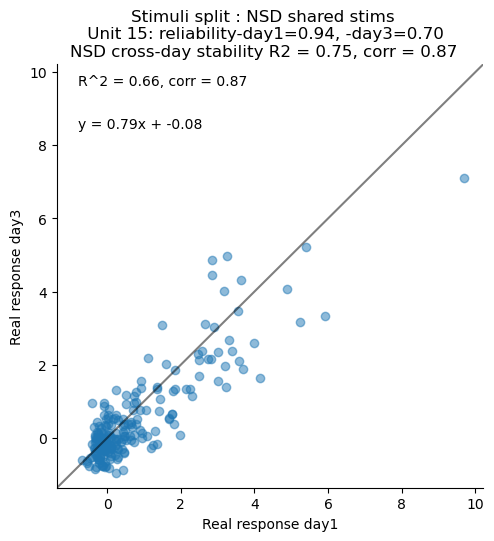

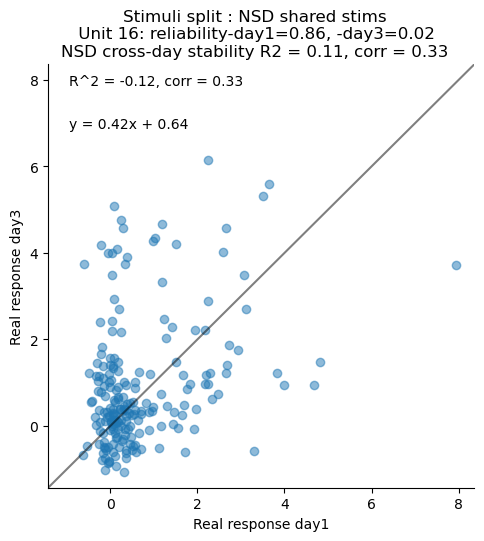

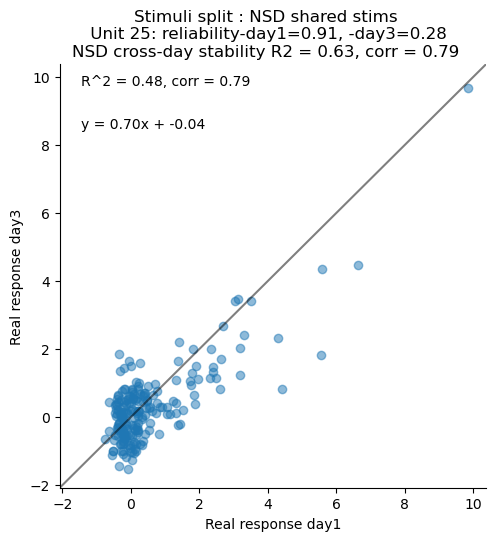

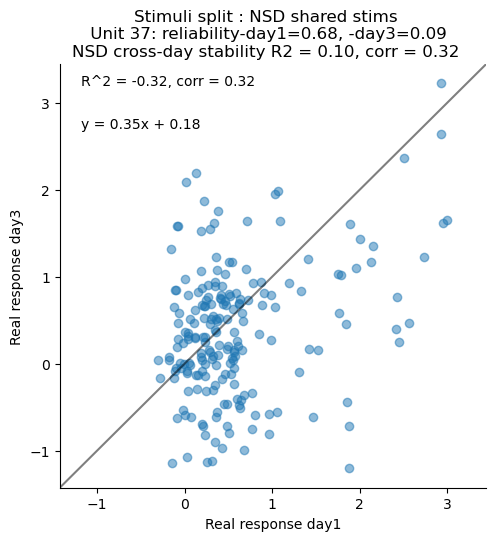

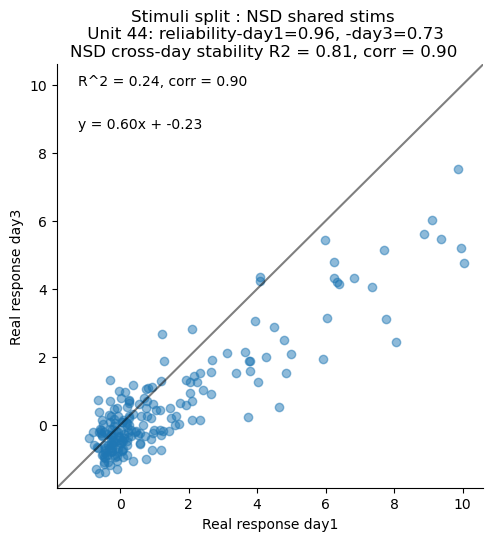

In [101]:
for channel in [1, 9, 15, 16, 25, 37, 44, ]:
    # split_str = f"accentuated and model == 'resnet50' and method == 'RidgeCV' and unit == {channel}"
    resp_actual_day3 = pred_data_day3["resp_mat"][idx_shared_day3, channel]
    resp_actual_day1 = pred_data_day1["resp_mat"][idx_shared_day1, channel]
    stability_R2 = stability_df.loc[channel, "R2_1to3"]
    stability_corr = stability_df.loc[channel, "corr"]
    reliability_day3 = data_dict_day3['reliability'][channel]
    reliability_day1 = data_dict_day1['reliability'][channel]
    figh, axs = plt.subplots(1, 1, figsize=(5.5, 5.5), sharex="row", sharey="row")
    plt.sca(axs)
    plt.scatter(resp_actual_day1, resp_actual_day3, alpha=0.5, cmap='tab10')
    annotate_scatter(axs, resp_actual_day3, resp_actual_day1)
    # annotate the equation of the line
    plt.text(0.05, 0.85, f"y = {stability_df.loc[channel, 'slope_1to3']:.2f}x + {stability_df.loc[channel, 'intercept_1to3']:.2f}", transform=axs.transAxes)
    plt.xlabel("Real response day1")
    plt.ylabel(f"Real response day3")
    plt.suptitle(f"Stimuli split : NSD shared stims\n Unit {channel}: reliability-day1={reliability_day1:.2f}, -day3={reliability_day3:.2f}\nNSD cross-day stability R2 = {stability_R2:.2f}, corr = {stability_corr:.2f}")
    plt.show()

In [46]:
stim_idxs

Index([3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009,
       ...
       3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109],
      dtype='int64', length=110)

In [31]:
# Keys for day 3 data
print("Day 3 data keys:")
print([
    "image_fps",
    "stimulus_names", 
    "resp_mat",
    "population_pred_day3_RN50_L4B1_Lasso",
    "population_pred_day3_RN50_L4B1_Ridge",
    "population_pred_day3_RN50rbst_L4B1_Lasso",
    "population_pred_day3_RN50rbst_L4B1_Ridge"
])

# Keys for day 1 data
print("\nDay 1 data keys:")
print([
    "image_fps",
    "stimulus_names",
    "resp_mat", 
    "population_pred_day1_RN50_L4B1_Lasso",
    "population_pred_day1_RN50_L4B1_Ridge",
    "population_pred_day1_RN50rbst_L4B1_Lasso",
    "population_pred_day1_RN50rbst_L4B1_Ridge"
])

Day 3 data keys:
['image_fps', 'stimulus_names', 'resp_mat', 'population_pred_day3_RN50_L4B1_Lasso', 'population_pred_day3_RN50_L4B1_Ridge', 'population_pred_day3_RN50rbst_L4B1_Lasso', 'population_pred_day3_RN50rbst_L4B1_Ridge']

Day 1 data keys:
['image_fps', 'stimulus_names', 'resp_mat', 'population_pred_day1_RN50_L4B1_Lasso', 'population_pred_day1_RN50_L4B1_Ridge', 'population_pred_day1_RN50rbst_L4B1_Lasso', 'population_pred_day1_RN50rbst_L4B1_Ridge']


In [ ]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "Stimuli", "shared1000") 
pilot_MACO_root = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
data_h5 = load_from_hdf5(data_path)
subject_id = 'red_20241212-20241220'
PCA_subject_id = 'red_20241212-20241220' # 'paul_20241119'
batch_size = 96 
device = "cuda" 
reliability_thresh = None
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
stim_names = data_dict['stimulus_names']
image_fps = parse_image_fullpaths(stim_names, [stimroot, pilot_MACO_root])
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
brain_area = [x.decode('utf-8') for x in data_dict['brain_area']]
idx_train, idx_test = train_test_split(
    np.arange(len(resp_mat)), test_size=0.2, random_state=42, shuffle=True
)
print(f"Loading data from {data_path}")
figroot = join(dataroot, "model_outputs")
figdir = join(dataroot, "model_outputs", subject_id, ) #+"_Lasso"

All stimulus files were found
Loading data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/vvs-accentuate-day1_normalize_red_20241212-20241220.h5
